In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import sys
import os.path as op
from tqdm.notebook import tqdm
import requests as req
from bs4 import BeautifulSoup as bs
import re
import time

from googleapiclient.errors import HttpError

sys.path.insert(0, '..') # project folder

from country_scraping import extract_channels_edu, youtube_country_scraper, youtube_handle_scraper, extract_countries_socialblade

path_data = op.join('..', 'data', 'raw')
path_deriv = op.join(path_data, '..', 'derivatives')
path_metadata = op.join(path_data, "yt_metadata_en.jsonl.gz")
path_edu = op.join(path_deriv, "Education_videos_{}.csv")
path_channels = op.join(path_data, "df_channels_en.tsv.gz")

API_KEY = pd.read_json(op.join('..','config.json'))['api_key'][0]
N_BATCHES = 8

<Axes: xlabel='month_year'>

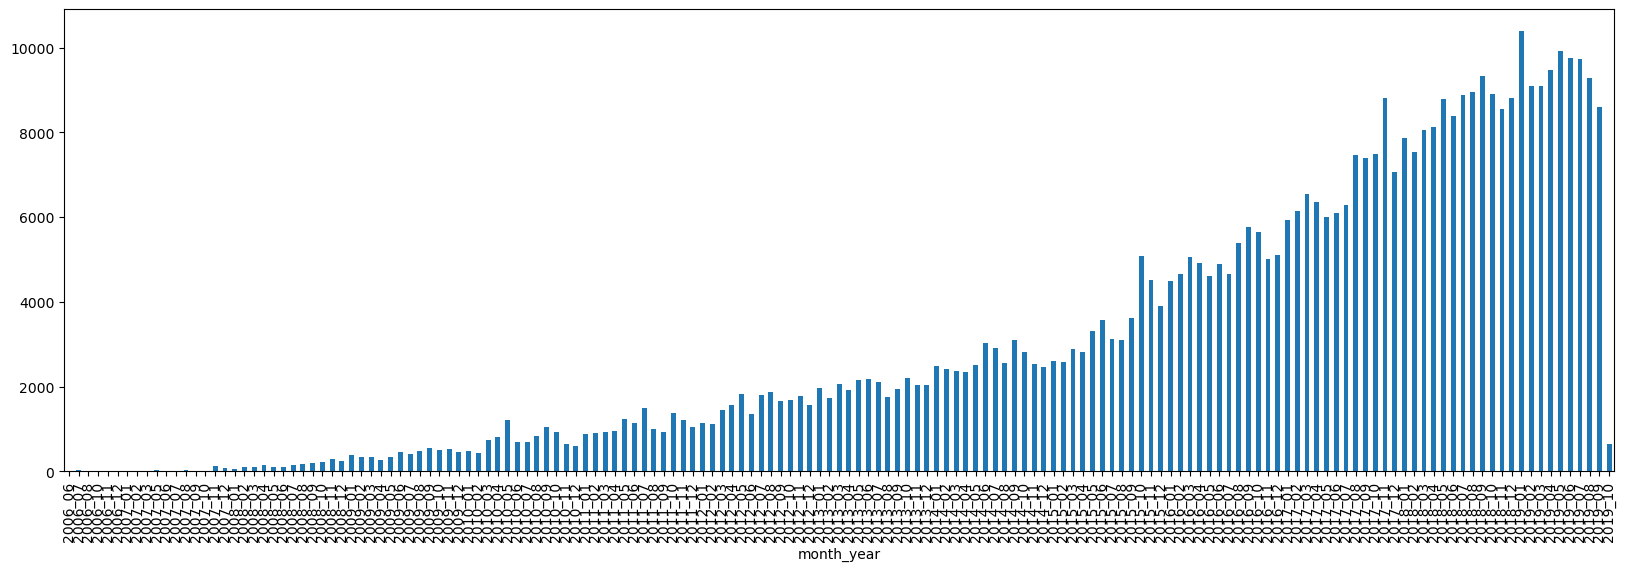

In [ ]:
df = pd.read_csv(op.join(path_edu.format(0)), index_col=0)
df['month_year'] = df['upload_date'].apply(lambda x: '_'.join(str(x).split('-')[:2]))
fig, ax = plt.subplots(figsize=(20, 6))
df.groupby(by='month_year').month_year.value_counts().plot(kind='bar', ax=ax)

### Channel extraction from Edu videos

In [ ]:
channels = extract_channels_edu(verbose = True)

Processing file : path_edu_0  --> Found 3412 channels
Processing file : path_edu_1  --> Found 3039 channels
Processing file : path_edu_2  --> Found 3069 channels
Processing file : path_edu_3  --> Found 3036 channels
Processing file : path_edu_4  --> Found 3384 channels
Processing file : path_edu_5  --> Found 3282 channels
Processing file : path_edu_6  --> Found 3150 channels
Processing file : path_edu_7  --> Found 3224 channels
Total number of channels : 25587


### Youtube API - extract the countries directly

In [ ]:
countries = pd.DataFrame(columns = ['channel_id', 'country']) 
countries['channel_id'] = channels
countries['country'] = 'empty'

In [ ]:
start = 0
end = len(countries) # max 10k per day - improved since now we do batches so can run all of them in one go
batch_size = 50 # max youtube allows per request

try:
    for i in tqdm(range(start,end,batch_size), total = (end - start)//batch_size, desc = 'Country extraction'):
        chs = channels[i:min(i+batch_size,end)]
        nations = youtube_country_scraper(API_KEY, chs, verbose= False)
        
        for ch in chs:
            countries.loc[countries.channel_id == ch, 'country'] = nations[ch]
            tqdm.write('Channel {} : {} - {}  '.format(i, ch, nations[ch]), end="\r")

    if end % batch_size != 0:
        chs_extra = channels[(end//batch_size)* batch_size:end]
        nations = youtube_country_scraper(API_KEY, chs_extra, verbose= False)
        for i, ch in enumerate(chs_extra):
            countries.loc[countries.channel_id == ch, 'country'] = nations[ch]
            tqdm.write('Channel {} : {} - {}  '.format(i, ch, nations[ch]), end="\r")

except HttpError as e:
        if e.resp.status == 403:
            print('Quota exceeded, saving extracted countries')
            countries.to_csv(op.join(path_deriv, 'countries.csv'), index = False)        

countries.to_csv(op.join(path_deriv, 'countries.csv'))
tqdm.write('Done!                                        ')

In [ ]:
#Redo those that did not return the same channel id
countries_redo = countries[countries.country == 'deleted'].reset_index(drop = True) 
for i, ch in tqdm(enumerate(countries_redo.channel_id), total = len(countries_redo)//10, desc = 'Countries redo'):
    nations = youtube_country_scraper(API_KEY, [ch], verbose= False)
    countries.loc[countries.channel_id == ch, 'country'] = nations[ch]
    tqdm.write('Channel {} : {} - {}  '.format(i, ch, nations[ch]), end="\r")

countries.to_csv(op.join(path_deriv, 'countries.csv'))

In [ ]:
pd.set_option("display.max_rows", None) #11 is default
display(countries.country.value_counts(dropna=True))

### Countplot of countries

In [92]:
#group in single category all the countries with less than 10 channels
countries = pd.read_csv(op.join(path_deriv, 'countries.csv'))
filter = 20
to_plot = countries.copy()
value_countss = to_plot['country'].value_counts()
to_plot['country'] = to_plot['country'].apply(lambda x: 'Other' if type(x) == str and value_countss[x] < filter  else x)
to_plot = to_plot[to_plot.country != 'Other']

to_plot.country.value_counts(dropna=False)
to_plot[to_plot.country == 'deleted'] = '?'
to_plot.country  = to_plot.country.fillna('?')

C:\Users\gbrag\AppData\Local\Temp\ipykernel_28728\2877193261.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '?' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  to_plot[to_plot.country == 'deleted'] = '?'


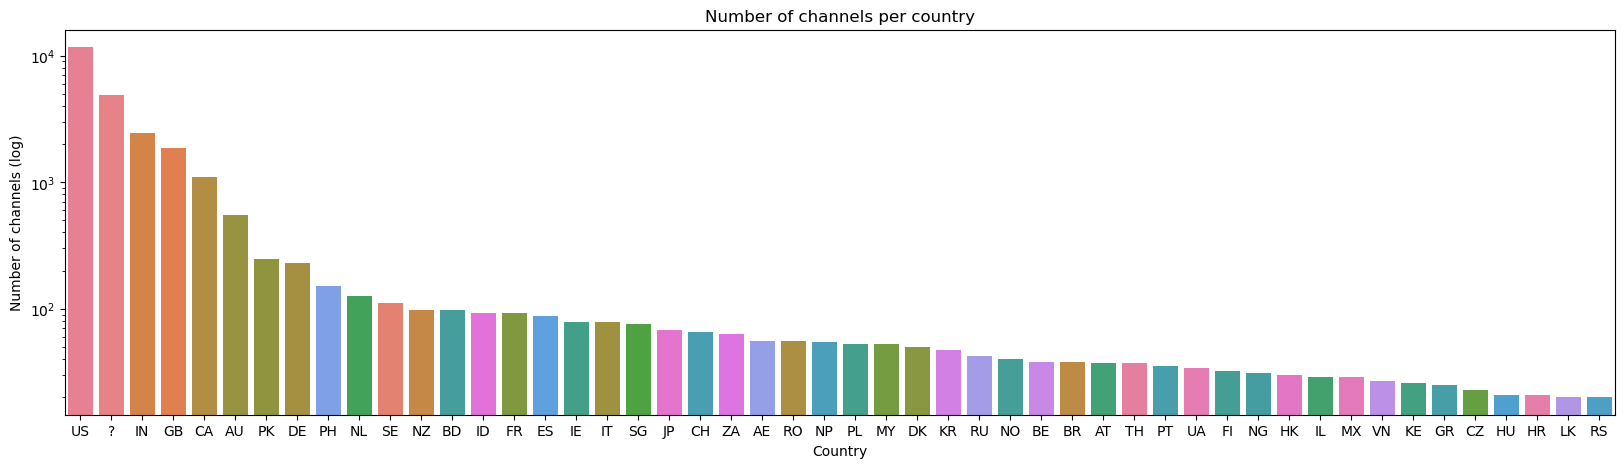

In [93]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.countplot(x='country', data=to_plot, order = to_plot['country'].value_counts(dropna=False).index, hue = 'country', ax=ax)
ax.set_yscale('log')
ax.set_title('Number of channels per country')
ax.set_xlabel('Country')
ax.set_ylabel('Number of channels (log)')
plt.show()
# ax.legend_.remove()

## Handling channels that Youtube API couldn't inform us about

In [28]:
pd.set_option("display.max_rows", 11)

In [52]:
if op.isfile(op.join(path_deriv, 'countries.csv')):
    countries = pd.read_csv(op.join(path_deriv, 'countries.csv'), index_col = 0)

In [53]:
# Merge the countries for which we have no info with the channel information to be able to crawl socialblade
channels = pd.read_csv(path_channels, compression="infer", sep="\t")
delNone = countries[(countries.country == 'deleted') | (countries['country'].apply(lambda x: isinstance(x, float)))]
delNone = delNone.rename(columns={'channel_id':'channel'})
no_country = pd.merge(delNone, channels, on='channel', how='left')
no_country['handle'] = None
#print('length before : ',len(deleted), ' and after : ', len(deleted_df))

#### Get the handles of the countries we could not get the country of

In [ ]:
start = 0
channels = no_country.channel.to_list()
end = len(channels) # max 10k per day - improved since now we do batches so can run all of them in one go
batch_size = 50 # max youtube allows per request

try:
    for i in tqdm(range(start,end,batch_size), total = (end - start)//batch_size, desc = 'Handle extraction'):
        chs = channels[i:min(i+batch_size,end)]
        handles = youtube_handle_scraper(chs, verbose= False)
        
        for ch in chs:
            no_country.loc[no_country.channel == ch, 'handle'] = handles[ch]
            tqdm.write('Channel {} : {} - {}             '.format(i, ch, handles[ch]), end="\r")

    if end % batch_size != 0:
        chs_extra = channels[(end//batch_size)* batch_size:end]
        handles = youtube_handle_scraper(chs_extra, verbose= False)
        for i, ch in enumerate(chs_extra):
            no_country.loc[no_country.channel == ch, 'handle'] = handles[ch]
            tqdm.write('Channel {} : {} - {}  '.format(i, ch, handles[ch]), end="\r")

except HttpError as e:
        if e.resp.status == 403:
            print('Quota exceeded, saving extracted countries')
            no_country.to_csv(op.join(path_deriv, 'no_country_handles.csv'), index = False)

no_country.handle = no_country.handle.apply(lambda x : x.replace('@','') if x is not None else x)
no_country.to_csv(op.join(path_deriv, 'no_country_handles.csv'))
tqdm.write('Done!                                        ')

Handle extraction:   0%|          | 0/97 [00:00<?, ?it/s]

Done!                                        sult      505                            


#### Try to get the countries through the archive

In [ ]:
from country_scraping import extract_countries_socialblade

#no_country= pd.read_csv(op.join(path_deriv, 'no_country_handles.csv'), index_col = 0)
codes = no_country['channel']
usernames = no_country['handle']

redo = ['api', 'attempts exhausted', 'request error', 'except', 'no_info' , 'None', 'wrong status code','no_info'] # iteratively run these until 
to_iterate = no_country[no_country.country.isin(redo)].handle.to_list() #usernames

for i, channel in tqdm(enumerate(to_iterate), total = len(to_iterate), desc='going through channels'):
    if channel != 'no_result' and isinstance(channel,str) :
        country = extract_countries_socialblade(user = channel, username=True)
        no_country.loc[no_country.handle == channel, 'country'] = country
    if i % 50 == 0:
        no_country.to_csv(op.join(path_deriv, f'countries_webarchive_handles.csv'), index = False)
no_country.to_csv(op.join(path_deriv, f'countries_webarchive_handles.csv'), index = False)

In [ ]:
# check where algorithm failed to retrieve information, to loop it back into algorithm
no_country[no_country.country.isin(redo + ['no_country'])].country.value_counts(dropna=False)

country
no_country    122
Name: count, dtype: int64

In [ ]:
# Visualize the countries we could get with this alternative method
#no_country[~no_country.country.isin(redo + ['no_rec', 'deleted','no_country'])].country.value_counts(dropna=False)
no_country.country.value_counts(dropna=False)

country
no_rec        2441
deleted       1245
US             686
no_country     122
GB              90
              ... 
SY               1
NZ               1
AD               1
RS               1
BS               1
Name: count, Length: 75, dtype: int64

In [ ]:
# _______ Postprocessing the no_country df
#no_country.loc[no_country.handle == 'no_result', 'country'] = 'deleted' # 1245 deleted channels
#no_country.loc[no_country.country == '', 'country'] = 'no_country'
#no_country.loc[no_country.country == '', 'attempts exhausted'] = 'no_country'
#no_country.loc[(no_country['handle'].apply(lambda x: isinstance(x, float))), 'country'] = 'no_info'
#no_country.loc[(no_country['handle'].apply(lambda x: isinstance(x, float))), 'handle'] = 'no_result'

In [ ]:
# the method with the codes yielded 3 new countries (for a third of the no_country dataset)
# the method with guessing the usernames yielded 100 new countries but with less certainty that these were the correct ones
# asking chat GPT for the handles did not prove to be  conclusive
# finally the method of asking youtube for the handle then asking the archive for the country yielded a bit more than 1000 new countries
# i manually set some problematic ones to 'no_info' or 'deleted' and some others to their country manually

# Combining them back into countries df

In [ ]:
no_country = pd.read_csv(op.join(path_deriv, 'countries_webarchive_handles.csv')).rename(columns = {'channel':'channel_id'})
countries = pd.read_csv(op.join(path_deriv, 'countries_old.csv'), index_col = 0)
countries.country = countries.country.apply(lambda x: x if isinstance(x, str) and x!= 'deleted' else None)
countries_all = pd.merge(countries, no_country[['channel_id','country']], on='channel_id', how='outer', suffixes=('', '_extra'))
countries_all['country'] = countries_all['country_extra'].combine_first(countries_all['country'])
countries_all = countries_all.drop(columns = 'country_extra')
countries_all.to_csv(op.join(path_deriv, 'countries.csv'))

In [118]:
pd.set_option("display.max_rows", 11) 
countries_all.country.value_counts(dropna=False)

country
US         12312
IN          2464
no_rec      2441
GB          1963
deleted     1245
           ...  
AI             1
BZ             1
ME             1
UM             1
SY             1
Name: count, Length: 126, dtype: int64

In [136]:
# redo plot
#group in single category all the countries with less than 10 channels
to_plot = pd.read_csv(op.join(path_deriv, 'countries.csv')).copy()
filter = 20
value_countss = to_plot['country'].value_counts()
to_plot['country'] = to_plot['country'].apply(lambda x: 'Other' if type(x) == str and value_countss[x] < filter  else x)
to_plot = to_plot[to_plot.country != 'Other']

# deleted and no_rec we dont have information so question mark
to_plot[to_plot.country == 'deleted'] = '?'
to_plot[to_plot.country == 'no_country'] = '-'
to_plot[to_plot.country == 'no_rec'] = '?'
to_plot.country = to_plot.country.fillna('?')

C:\Users\gbrag\AppData\Local\Temp\ipykernel_31968\1002662812.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '?' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  to_plot[to_plot.country == 'deleted'] = '?'


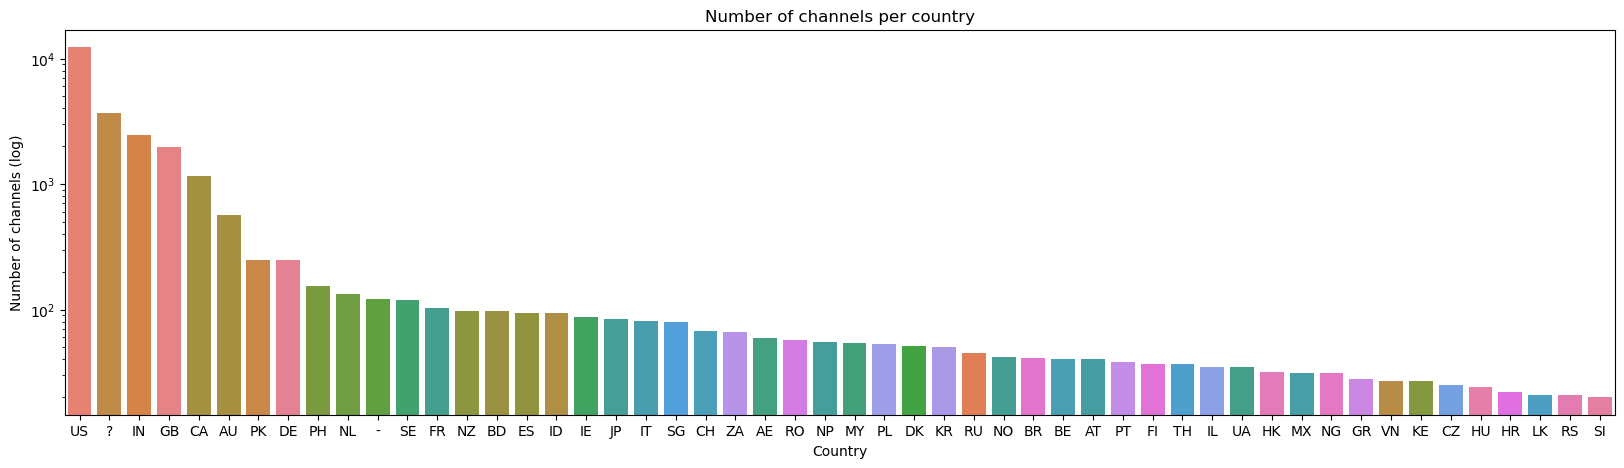

In [137]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.countplot(x='country', data=to_plot, order = to_plot['country'].value_counts(dropna=False).index, hue = 'country', ax=ax)
ax.set_yscale('log')
ax.set_title('Number of channels per country')
ax.set_xlabel('Country')
ax.set_ylabel('Number of channels (log)')
#ax.legend_.remove()
plt.show()

## Other explored methods - Socialblade directly, webarchive top lists

In [ ]:
#Socialblade has a paid API

#import requests as req
#from bs4 import BeautifulSoup as bs
"""url = r'https://socialblade.com/youtube/c/simonegiertz'
r = req.get(url)
print('Response status code: {0}\n'.format(r.status_code))
soup = bs(r.text, 'html.parser')
country = soup.find('span', {'id': 'youtube-stats-header-country'}).text
print(country)"""

In [ ]:
#Web archive for Socialblade - solution not practical because you have to find the exact date of the snapshot - improved above through using the webarchive API
"""url = r'https://web.archive.org/web/20161218062757/https://socialblade.com/youtube/user/leafyishere/monthly'
r = req.get(url)
print('Response status code: {0}\n'.format(r.status_code))
soup = bs(r.text, 'html.parser')
country = soup.find('span', {'id': 'youtube-stats-header-country'}).text
print(country)"""

In [ ]:
# The logic here is to crawl the top channels of their country so that if this channel has been deleted we can still have its country, 
# we are thus favoring the biggest channels but also the biggest countries since a random search in socialblade revealed that among deleted these were the most common countries
# we scrape two dates only since the url search is done by hand 

# THIS APPROACH DID NOT YIELD MUCH RESULTS
links_country = ['https://web.archive.org/web/20161222044632/http://socialblade.com/youtube/top/country/US',
                   'https://web.archive.org/web/20161222072007/http://socialblade.com/youtube/top/country/us/mostsubscribed',
                   'https://web.archive.org/web/20161222072024/http://socialblade.com/youtube/top/country/us/mostviewed',
                   'https://web.archive.org/web/20161222044658/http://socialblade.com/youtube/top/country/au',
                   'https://web.archive.org/web/20161222072954/http://socialblade.com/youtube/top/country/au/mostsubscribed',
                   'https://web.archive.org/web/20161222073230/http://socialblade.com/youtube/top/country/au/mostviewed',
                   'https://web.archive.org/web/20161222044703/http://socialblade.com/youtube/top/country/ca',
                   'https://web.archive.org/web/20161229071141/http://socialblade.com/youtube/top/country/ca/mostsubscribed',
                   'https://web.archive.org/web/20161229071159/http://socialblade.com/youtube/top/country/ca/mostviewed',
                   'https://web.archive.org/web/20161229050027/http://socialblade.com/youtube/top/country/gb',
                   'https://web.archive.org/web/20161229065353/http://socialblade.com/youtube/top/country/gb/mostsubscribed',
                   'https://web.archive.org/web/20161229065406/http://socialblade.com/youtube/top/country/gb/mostviewed',
                   'https://web.archive.org/web/20161119014022/http://socialblade.com/youtube/top/country/in',
                   'https://web.archive.org/web/20161119181439/http://socialblade.com/youtube/top/country/in/mostsubscribed',
                   'https://web.archive.org/web/20161202092130/http://socialblade.com/youtube/top/country/in/mostviewed',
                   'https://web.archive.org/web/20161119021551/http://socialblade.com/youtube/top/country/pk',
                   'https://web.archive.org/web/20161119065202/http://socialblade.com/youtube/top/country/pk/mostsubscribed',
                   'https://web.archive.org/web/20161119234149/http://socialblade.com/youtube/top/country/pk/mostviewed',
                   'https://web.archive.org/web/20161119002647/http://socialblade.com/youtube/top/country/de',
                   'https://web.archive.org/web/20161119021541/http://socialblade.com/youtube/top/country/de/mostsubscribed',
                   'https://web.archive.org/web/20161119181429/http://socialblade.com/youtube/top/country/de/mostviewed',
                   'https://web.archive.org/web/20161130221530/http://socialblade.com/youtube/top/country/ph',
                   'https://web.archive.org/web/20161130221536/http://socialblade.com/youtube/top/country/ph/mostsubscribed',
                   'https://web.archive.org/web/20161130155016/http://socialblade.com/youtube/top/country/ph/mostviewed',
                   'https://web.archive.org/web/20161119065157/http://socialblade.com/youtube/top/country/nl',
                   'https://web.archive.org/web/20161120184457/http://socialblade.com/youtube/top/country/nl/mostsubscribed',
                   'https://web.archive.org/web/20161123080436/http://socialblade.com/youtube/top/country/nl/mostviewed',
                   'https://web.archive.org/web/20161121061011/http://socialblade.com/youtube/top/country/se',
                   'https://web.archive.org/web/20161130221540/http://socialblade.com/youtube/top/country/se/mostsubscribed',
                   'https://web.archive.org/web/20170224131438/http://socialblade.com/youtube/top/country/se/mostviewed',
                   'https://web.archive.org/web/20161127085334/http://socialblade.com/youtube/top/country/nz',
                   'https://web.archive.org/web/20161122173341/http://socialblade.com/youtube/top/country/nz/mostsubscribed',
                   'https://web.archive.org/web/20161127132852/http://socialblade.com/youtube/top/country/nz/mostviewed',

                   'https://web.archive.org/web/20140329221609/http://socialblade.com/youtube/top/country/US',
                   'https://web.archive.org/web/20140329235335/http://socialblade.com/youtube/top/country/US/mostsubscribed',
                   'https://web.archive.org/web/20140329235338/http://socialblade.com/youtube/top/country/US/mostviewed',
                   'https://web.archive.org/web/20140329221613/http://socialblade.com/youtube/top/country/GB',
                   'https://web.archive.org/web/20140329235344/http://socialblade.com/youtube/top/country/GB/mostsubscribed',
                   'https://web.archive.org/web/20140329235349/http://socialblade.com/youtube/top/country/GB/mostviewed',
                   'https://web.archive.org/web/20140329221616/http://socialblade.com/youtube/top/country/AU',
                   'https://web.archive.org/web/20140329235644/http://socialblade.com/youtube/top/country/AU/mostsubscribed',
                   'https://web.archive.org/web/20140329235652/http://socialblade.com/youtube/top/country/AU/mostviewed',
                   'https://web.archive.org/web/20140329221619/http://socialblade.com/youtube/top/country/CA',
                   'https://web.archive.org/web/20140330000114/http://socialblade.com/youtube/top/country/CA/mostsubscribed',
                   'https://web.archive.org/web/20140330000119/http://socialblade.com/youtube/top/country/CA/mostviewed',
                   'https://web.archive.org/web/20140318191804/http://socialblade.com/youtube/top/country/IN',
                   'https://web.archive.org/web/20140301072718/http://socialblade.com/youtube/top/country/IN/mostsubscribed',
                   'https://web.archive.org/web/20140219090930/http://socialblade.com/youtube/top/country/IN/mostviewed',
                   'https://web.archive.org/web/20140313100549/http://socialblade.com/youtube/top/country/PK',
                   'https://web.archive.org/web/20140724211914/http://socialblade.com/youtube/top/country/PK/mostsubscribed',
                   'https://web.archive.org/web/20140726062807/http://socialblade.com/youtube/top/country/PK/mostviewed',
                   'https://web.archive.org/web/20140728125858/http://socialblade.com/youtube/top/country/DE',
                   'https://web.archive.org/web/20140728151629/http://socialblade.com/youtube/top/country/DE/mostsubscribed',
                   'https://web.archive.org/web/20140728151641/http://socialblade.com/youtube/top/country/DE/mostviewed',
                   'https://web.archive.org/web/20140503064338/http://socialblade.com/youtube/top/country/PH',
                   'https://web.archive.org/web/20140521080641/http://socialblade.com/youtube/top/country/PH/mostsubscribed',
                   'https://web.archive.org/web/20140521082425/http://socialblade.com/youtube/top/country/PH/mostviewed',
                   'https://web.archive.org/web/20140504103707/http://socialblade.com/youtube/top/country/NL',
                   'https://web.archive.org/web/20140427110000/http://socialblade.com/youtube/top/country/NL/mostsubscribed',
                   'https://web.archive.org/web/20140216200300/http://socialblade.com/youtube/top/country/NL/mostviewed',
                   'https://web.archive.org/web/20140504103947/http://socialblade.com/youtube/top/country/SE',
                   'https://web.archive.org/web/20140517204258/http://socialblade.com/youtube/top/country/SE/mostsubscribed',
                   'https://web.archive.org/web/20140921004212/http://socialblade.com/youtube/top/country/SE/mostviewed',
                   'https://web.archive.org/web/20140508220634/http://socialblade.com/youtube/top/country/NZ',
                   'https://web.archive.org/web/20140505062836/http://socialblade.com/youtube/top/country/NZ/mostsubscribed',
                   'https://web.archive.org/web/20140505065259/http://socialblade.com/youtube/top/country/NZ/mostviewed'
                   ]

liks_top =['https://web.archive.org/web/20161222050636/http://socialblade.com/youtube/top/5000',
           'https://web.archive.org/web/20161201234302/http://socialblade.com/youtube/top/5000/mostsubscribed',
           'https://web.archive.org/web/20161201234305/http://socialblade.com/youtube/top/5000/mostviewed',
           'https://web.archive.org/web/20161128234930/http://socialblade.com/youtube/top/category/education',
           'https://web.archive.org/web/20161119012425/http://socialblade.com/youtube/top/bottom50030d/mostunsubscribed',
           'https://web.archive.org/web/20160427033433/http://socialblade.com/youtube/top/bottom50030d/mostunsubscribed',
           'https://web.archive.org/web/20150629035707/http://socialblade.com/youtube/top/bottom50030d/mostunsubscribed',
           'https://web.archive.org/web/20140601022314/http://socialblade.com/youtube/top/bottom50030d/mostunsubscribed',
           'https://web.archive.org/web/20131205214715/http://socialblade.com/youtube/top/bottom50030d/mostunsubscribed',
           ]



def extract_countries_socialblade_manual_url(url, dict, retries= 5):
    for i in range(retries):
        try:
            r = req.get(url)
            break
        except req.exceptions.ConnectionError as e:
            print(e)
            time.sleep(3) # seconds
    
    value =  url.split("country/")[-1].split('/')[0].lower() # get the country as per the link 
    if r.status_code == 200:
        soup = bs(r.text, 'html.parser')
        youtube_user_links = soup.find_all("a", href=re.compile(r"youtube/user/"))

        for link in youtube_user_links:
            href = link.get("href")
            channel = href.split('/')[-1]
            dict[channel] = value
    else:
        print(r.status_code)
    return dict 

socialblade_scraped = {}
for i, url in enumerate(links_country):
    socialblade_scraped = extract_countries_socialblade_manual_url(url, socialblade_scraped)

In [ ]:
socialblade = pd.DataFrame(list(socialblade_scraped.items()), columns =['name_cc', 'country'])
socialblade.to_csv(op.join(path_deriv, 'countries_tops_socialblade.csv'))